In [ ]:
!pip install datasets
!pip install zstandard
!pip install transformers

import torch
import copy
from torch.utils.data import DataLoader
import json
from datasets import load_dataset
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from transformers.optimization import AdamW
from common_code import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 9.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 76.7 MB/s eta 0:00

In [ ]:
## Params
n_new_models = 5 
noise_variance =  0.01
bs = 8
samplelength = 50
nbatches =  500

In [ ]:
## Model and tokenizer
model = GPTNeoXForCausalLM.from_pretrained(
  "EleutherAI/pythia-1.4B-deduped",
  revision="step143000",
  cache_dir="./pythia-1.4B-deduped/step143000",
)

tokenizer = AutoTokenizer.from_pretrained(
  "EleutherAI/pythia-1.4B-deduped",
  revision="step143000",
  cache_dir="./pythia-1.4B-deduped/step143000",
)

model_name = "EleutherAI/pythia-1.4B-deduped"
model_revision = "step143000"
model_cache_dir = "./pythia-1.4B-deduped/step143000"

device = "cuda" if torch.cuda.is_available() else "cpu"

model.half()
model.eval()
model.to(device)
mem_stats()

Total Memory: 14.75 GB
Reserved Memory: 0.00 GB (0.00%)
Remaining Memory: 14.75 GB (100.00%)
---------------------------------
Allocated Memory: 0.00 GB (0.00%)
Percent of Reserved Allocated: 100.00%



In [ ]:
## Collate functions for loading dataset
def collate_fn(batch):
    tokens = [tokenizer.encode(example["text"], return_tensors="pt", truncation=True) for example in batch]
    max_length = max([t.size(1) for t in tokens])
    tokens_padded = [torch.cat([t, t.new_zeros(t.size(0), max_length - t.size(1))], dim=1) for t in tokens]
    tokens_padded = torch.cat(tokens_padded, dim=0)
    return tokens_padded

def collate_already_encoded(batch):
    tokens = batch
    max_length = max([len(t['tokens']) for t in tokens])
    tokens_padded = torch.zeros((len(tokens),max_length),dtype=torch.int)
    for i in range(len(tokens)):
        tokens_padded[i,:] = torch.Tensor(tokens[i]['tokens'])
    return tokens_padded

In [ ]:
def compare_models(new_model, n_new_models, noise_variance, 
                   dataloader, nbatches, bs, samplelength, device):
  
  new_model.eval()
  new_model.to(device)
  ans = torch.zeros((n_new_models+1, nbatches, bs))  
  
  ans[0,:,:] = compute_dataloader_cross_entropy(dataloader, nbatches, bs, device, new_model, samplelength)

  for ind_model in range(1,n_new_models+1):
    prevseed = torch.seed()
    with torch.no_grad():
      for param in new_model.parameters():
          param.add_((torch.randn(param.size()) * noise_variance).to(device))
    
    ans[ind_model,:,:] = compute_dataloader_cross_entropy(dataloader, nbatches, bs, device, new_model, samplelength)

    torch.manual_seed(prevseed)
    with torch.no_grad():
      for param in new_model.parameters():
          param.add_(-(torch.randn(param.size()) * noise_variance).to(device))

    if ind_model % 5 == 0:
      print(ind_model)
      mem_stats()
  return ans 

In [ ]:
training_dataset = load_dataset("EleutherAI/pile-deduped-pythia-random-sampled", split="train")
validation_dataset = load_dataset("the_pile_val.py", split="validation") 

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/5000000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/EleutherAI___parquet/EleutherAI--pile-deduped-pythia-random-sampled-ef6db9ddd170a4bc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [ ]:
training_dataloader = DataLoader(training_dataset, batch_size = bs, collate_fn=collate_already_encoded)
validation_dataloader = DataLoader(validation_dataset, batch_size = bs, collate_fn=collate_fn)



In [ ]:
training = compare_models(model, n_new_models, noise_variance, training_dataloader, nbatches, bs, samplelength, device)
validation = compare_models(model, n_new_models, noise_variance, validation_dataloader, nbatches, bs, samplelength, device)

batch no.  0
Memory after training
Total Memory: 14.75 GB
Reserved Memory: 2.92 GB (19.80%)
Remaining Memory: 11.83 GB (80.20%)
---------------------------------
Allocated Memory: 2.89 GB (19.57%)
Percent of Reserved Allocated: 98.85%


batch no.  50
Memory after training
Total Memory: 14.75 GB
Reserved Memory: 2.92 GB (19.80%)
Remaining Memory: 11.83 GB (80.20%)
---------------------------------
Allocated Memory: 2.89 GB (19.57%)
Percent of Reserved Allocated: 98.85%


batch no.  100
Memory after training
Total Memory: 14.75 GB
Reserved Memory: 2.92 GB (19.80%)
Remaining Memory: 11.83 GB (80.20%)
---------------------------------
Allocated Memory: 2.89 GB (19.57%)
Percent of Reserved Allocated: 98.85%


batch no.  150
Memory after training
Total Memory: 14.75 GB
Reserved Memory: 2.92 GB (19.80%)
Remaining Memory: 11.83 GB (80.20%)
---------------------------------
Allocated Memory: 2.89 GB (19.57%)
Percent of Reserved Allocated: 98.85%


batch no.  200
Memory after training
Total Memo

In [ ]:
train_flat = training.flatten(start_dim=1)
valid_flat = validation.flatten(start_dim=1)

train_diff = train_flat[0,:]-train_flat[1:,:].mean(dim=0)#/train_flat[1:,:].std(dim=0)
valid_diff = valid_flat[0,:]-valid_flat[1:,:].mean(dim=0)#/ valid_flat[1:,:].std(dim=0)


tensor(-3.3105) tensor(-0.0873)


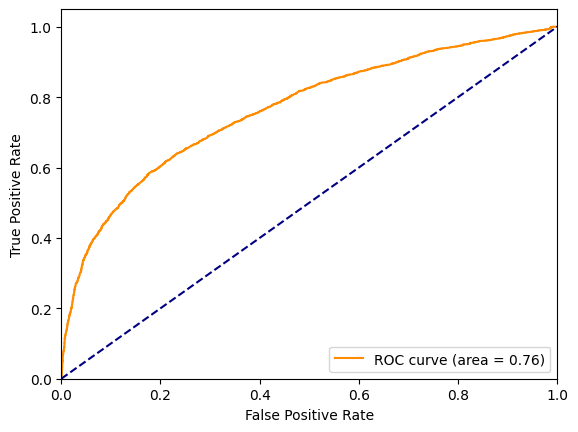

In [ ]:
plot_hist(train_diff, val_diff, show_plot = True, 
            save_plot=True, 
            plot_title = model_title + " Histogram (#new models="+n_new_models
                                      +", noise_var= , "+str(noise_variance)
                                      + "+bs=" + str(bs)
                                      +", nbatches="+str(nbatches)
                                      +", length="+str(samplelength)+")",
            plot_name=model_title +  " Histogram (#new models="+n_new_models
                                      +", noise_var= , "
                                      +noise_variance 
                                      + "+bs=" + str(bs)
                                      +", nbatches="+str(nbatches)
                                      +", length="+str(samplelength)+").png")


plot_ROC(train_diff, val_diff, show_plot = True, save_plot = True, log_scale = False, 
        plot_title =model_title + " ROC (#new models="+n_new_models
                                      +", noise_var= , "+str(noise_variance)
                                      + "+bs=" + str(bs)
                                      +", nbatches="+str(nbatches)
                                      +", length="+str(samplelength)+")", 
        plot_name = model_title + " ROC (#new models="+n_new_models
                                      +", noise_var= , "
                                      +noise_variance 
                                      + "+bs=" + str(bs)
                                      +", nbatches="+str(nbatches)
                                      +", length="+str(samplelength)+").png")